In [1]:
from imghdr import test_tiff

import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import seaborn as sns

import warnings
from collections import Counter

from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import re

warnings.filterwarnings("ignore")

In [2]:
def isNaN(sum):
    return sum!=sum

def ticket(t):
    try:
        return int(t.split()[-1])
    except:
        return np.nan
def transform_ticket(tickets:np.array):
    tickets = tickets.values.flatten()
    return np.array([ticket(t) for t in tickets]).reshape((1,-1))

def cabin(c):
    try:
        return c[0]
    except:
        return c

def transform_cabin(cabins: np.ndarray[str]) -> np.ndarray[str]:
    cabins = cabins.values.flatten()
    nouveaux = [cabin(x) for x in cabins]
    return np.array(nouveaux).reshape(-1, 1)


def transform_name(name : np.ndarray[str]) -> np.ndarray[str]:
    name = np.array(name)
    name = name.flatten()
    name = [re.search(r' ([A-Za-z]+)\.', n).group(1) for n in name]
    rare_titles = ['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']
    nouveaux_noms = [x if x in ['Mr', 'Mrs', 'Miss', 'Master'] else 'Rare' for x in name]
    return np.array(nouveaux_noms).reshape(-1,1)

def plot_corelation(df, annot = True):
    plt.figure(figsize = (10,8))
    correlation = df.corr()
    sns.heatmap(correlation, 
                annot=annot,
                cmap=sns.color_palette("vlag", as_cmap=True),
                cbar_kws={'shrink': .8},
                annot_kws={"size": 6})
    plt.title("Correlation Matrix Heatmap")
    plt.show()
    
    
def plot_learning_curves(estimator, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )
    
    # Moyenne et écart-type des scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Tracer les courbes
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Score entraînement')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Score validation')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.1)
    
    plt.title("Courbes d'apprentissage")
    plt.xlabel("Taille des données d'entraînement")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
data = pd.read_csv('data/train.csv', sep=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
y = data.Survived
data.drop(columns=['Survived'], inplace=True)
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=0)

print(x_train.shape, x_test.shape)
df = x_train.copy()

(623, 11) (268, 11)


In [5]:
print(x_train.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            121
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          471
Embarked         2
dtype: int64


In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        
        ('ticket', Pipeline([
            ('ticket_transform', FunctionTransformer(lambda x: np.array(transform_ticket(x)).reshape(-1, 1)))
        ]), ['Ticket']),
        
        ('sex', FunctionTransformer(lambda x: (x.values == 'male').astype(int).reshape(-1, 1)), ['Sex']),

        ('name', Pipeline([

            ('sort', FunctionTransformer(lambda x: np.array(transform_name(x)).reshape(-1, 1))), 
            ('name_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), ['Name']),
               

        ('embarked', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Embarked']),

        ('cabin', Pipeline([
            ('to_letter', FunctionTransformer(lambda x: np.array(transform_cabin(x)).reshape(-1, 1))),
            ('cabin_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), ['Cabin']),
    ],
    remainder='passthrough'
)

In [7]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ticket',
                                 Pipeline(steps=[('ticket_transform',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002168CFE2040>))]),
                                 ['Ticket']),
                                ('sex',
                                 FunctionTransformer(func=<function <lambda> at 0x000002168CFE21F0>),
                                 ['Sex']),
                                ('name',
                                 Pipeline(steps=[('sort',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002168...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Name']),
                                ('embarked',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Embarked']),
                                ('cabin',
                                 Pipeline(steps=[('to_letter',
                                                  FunctionTransformer(func=<function <lambda> at 0x000002168CFE2430>)),
                                                 ('cabin_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Cabin'])])

In [8]:
x_train_transformed = preprocessor.fit_transform(x_train)
x_train_transformed = np.reshape(np.array(x_train_transformed).ravel(), x_train_transformed.shape)

type(x_train_transformed),x_train_transformed.shape

(numpy.ndarray, (623, 26))

In [9]:
inputer = IterativeImputer(estimator=BayesianRidge(),
                           max_iter=10,
                            random_state=0)

inputer.fit(x_train_transformed)

IterativeImputer(estimator=BayesianRidge(), random_state=0)

In [10]:
train = inputer.transform(x_train_transformed)
type(train), train.shape

(numpy.ndarray, (623, 26))

### Maintenant on prend le test set et on applique le même préprocessing mais sans faire de fit sur le test !

In [11]:
x_test_transformed = preprocessor.transform(x_test)
x_test_transformed = np.reshape(np.array(x_test_transformed).ravel(), x_test_transformed.shape)

test = inputer.transform(x_test_transformed)

print(test.shape, type(test))

(268, 26) <class 'numpy.ndarray'>


In [12]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

model.fit(train, y_train) 

GradientBoostingClassifier()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model.score(test,y_test)
y_pred = model.predict(test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

Accuracy: 0.840
Precision: 0.806
Recall: 0.750
F1-Score: 0.777
ROC AUC: 0.821


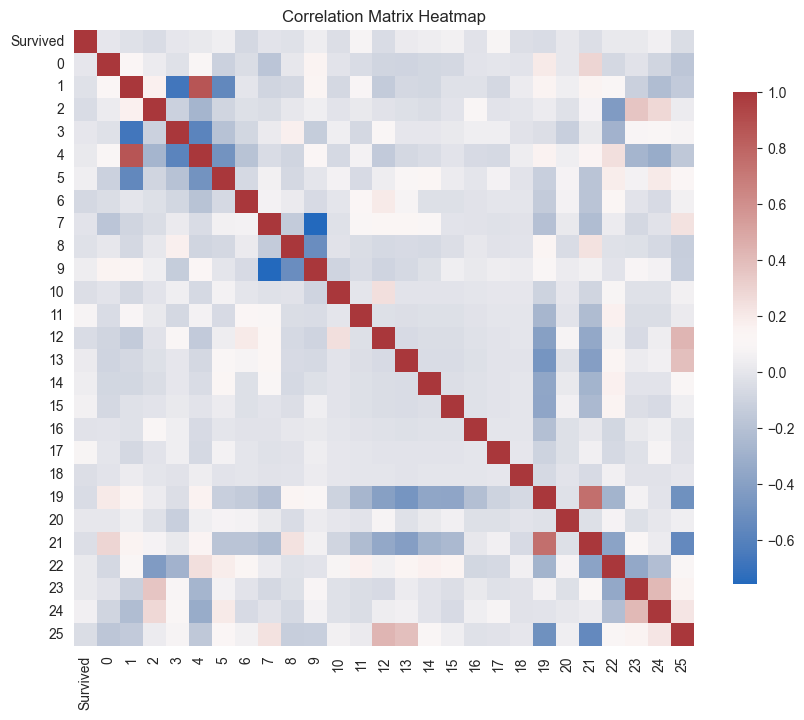

In [14]:
plot_corelation(pd.concat([y_train,pd.DataFrame(train)], axis = 1), False)

In [15]:
# param_grid = {
#     'n_estimators': [50, 100, 400, 700, 1000],  
#     'max_depth': [1, 10, 20, 30],  
#     'min_samples_split': [2, 4, 10, 12, 16],  
#     'min_samples_leaf': [1, 5, 10]    
# }
# 
# scorer = make_scorer(recall_score)
# randomforest = RandomForestClassifier(criterion='gini', bootstrap=True, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
# grid_search = GridSearchCV(estimator=randomforest, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
# grid_search.fit(train, y_train)
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# 
# print("Meilleurs paramètres :", best_params)
# print("Meilleur score de rappel (cross-validation) :", best_score)
# 
# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(test)
# 
# # Calcul des métriques
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred)
# 
# # Affichage des résultats
# print(f"Accuracy: {accuracy:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")
# print(f"ROC AUC: {roc_auc:.2f}")
# 
# y_pred = best_rf.predict(final_x)
# y_pred = pd.DataFrame({'PassengerId':x_final.PassengerId,'Survived': y_pred})
# 
# y_pred.to_csv('predictions.csv', index = False)

# Résultat du GridSearch

Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Meilleur score de rappel (cross-validation) : 0.7188775510204082
Accuracy: 0.84
Precision: 0.80
Recall: 0.75
F1-Score: 0.77
ROC AUC: 0.82

Accuracy: 0.98
Precision: 0.99
Recall: 0.96
F1-Score: 0.97
ROC AUC: 0.98


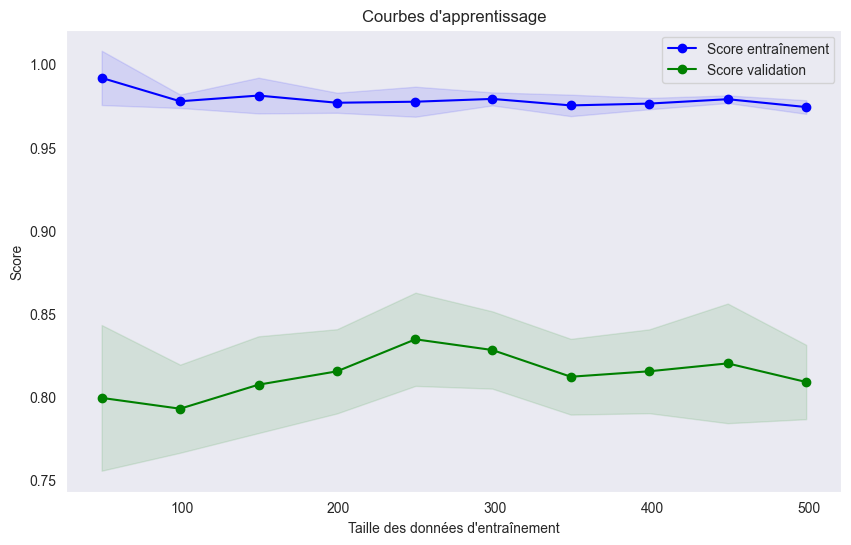

In [16]:
n_features = train.shape[1]

randomforest = RandomForestClassifier(criterion='gini',
                                      n_estimators=100,
                                      min_samples_leaf=1,
                                      min_samples_split=4,
                                      max_depth=20, 
                                      bootstrap=True,
                                      max_features=int(np.sqrt(n_features)),
                                      oob_score=True,
                                      random_state=1,
                                      n_jobs=100)
randomforest.fit(train, y_train)
y_pred = randomforest.predict(train)

# Calcul des métriques
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")


plot_learning_curves(randomforest, train, y_train, cv=5)


# OverFitting 

voici les résultats sur le jeu de train:
Accuracy: 0.98
Precision: 0.99
Recall: 0.96
F1-Score: 0.97
ROC AUC: 0.98

Tandis que sur le test : 
Accuracy: 0.84
Precision: 0.80
Recall: 0.75
F1-Score: 0.77
ROC AUC: 0.82

On est clairement sur un scénario d'overfitting, il faut donc changer le modèle et investiguer les données.

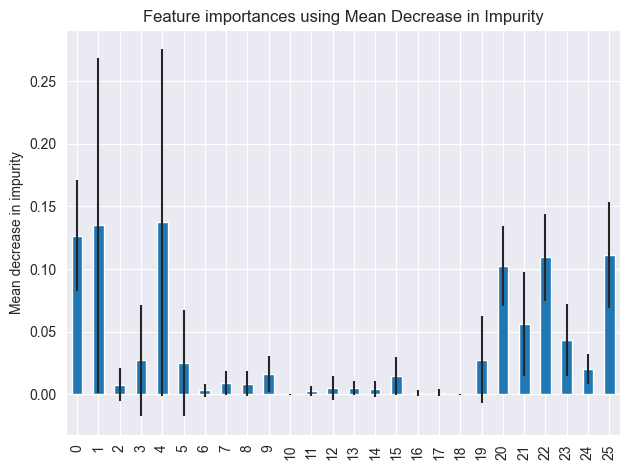

In [17]:
features_importance = randomforest.feature_importances_
features_names = [i for i in range(train.shape[1])]
features_importance = pd.Series(features_importance, index=features_names)
importances_per_tree = []
for tree in randomforest.estimators_:
    importances_per_tree.append(tree.feature_importances_)
importances_per_tree = np.array(importances_per_tree)
std = np.std(importances_per_tree, axis=0)

fig, ax = plt.subplots()
features_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [18]:
print(train.shape[1])

26


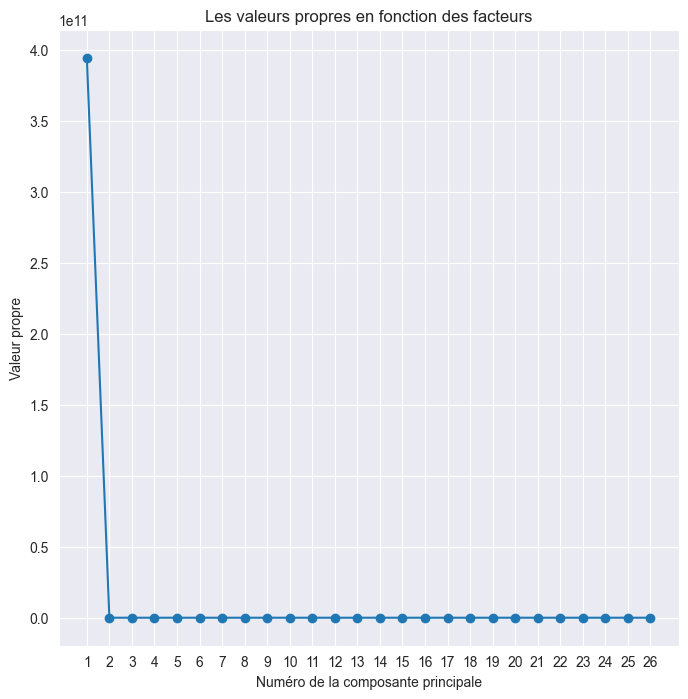

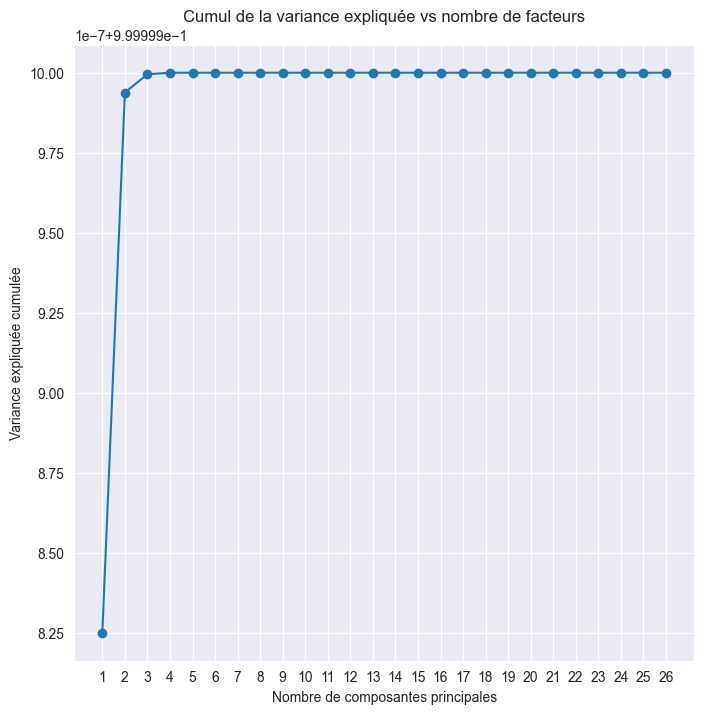

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialisation et transformation de l'ACP
pca = PCA()
train_pca = pca.fit_transform(train)

n = train.shape[0]
p = train.shape[1]
eigenvalues = (n - 1) / n * pca.explained_variance_

# Graphique 1 : Les valeurs propres en fonction des facteurs
fig, axes = plt.subplots(figsize=(8, 8))
axes.set_xticks(np.arange(1, p + 1))
axes.plot(range(1, p + 1), eigenvalues, marker='o', linestyle='-')
axes.set_xlabel("Numéro de la composante principale")
axes.set_ylabel("Valeur propre")
axes.set_title("Les valeurs propres en fonction des facteurs")
axes.grid(True)

# Graphique 2 : Cumul de la variance expliquée vs nombre de facteurs
fig, axes = plt.subplots(figsize=(8, 8))
axes.set_xticks(np.arange(1, p + 1))
axes.plot(np.arange(1, p + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
axes.set_xlabel("Nombre de composantes principales")
axes.set_ylabel("Variance expliquée cumulée")
axes.set_title("Cumul de la variance expliquée vs nombre de facteurs")

axes.grid(True)

plt.show()


In [20]:
feature_minimum = 0.01
features_to_keep = features_importance[features_importance > feature_minimum].index.tolist()
train = pd.DataFrame(train)
train = train.loc[:, features_to_keep]

randomforest = RandomForestClassifier(random_state=42)

# grille des hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],            
    'max_depth': [5, 10, 15, None],             
    'max_features': ['sqrt', 'log2', None],     
    'min_samples_split': [2, 5, 10],            
    'min_samples_leaf': [1, 2, 5, 10]           
}

# Configurer le GridSearchCV
grid_search = GridSearchCV(
    estimator=randomforest,
    param_grid=param_grid,
    cv=5,                     
    scoring='accuracy',       
    n_jobs=-1,               
    verbose=2
)

grid_search.fit(train, y_train)

print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score de validation :", grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Meilleurs paramètres trouvés : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Meilleur score de validation : 0.8251096774193549


Accuracy: 0.83
Precision: 0.77
Recall: 0.77
F1-Score: 0.77
ROC AUC: 0.82


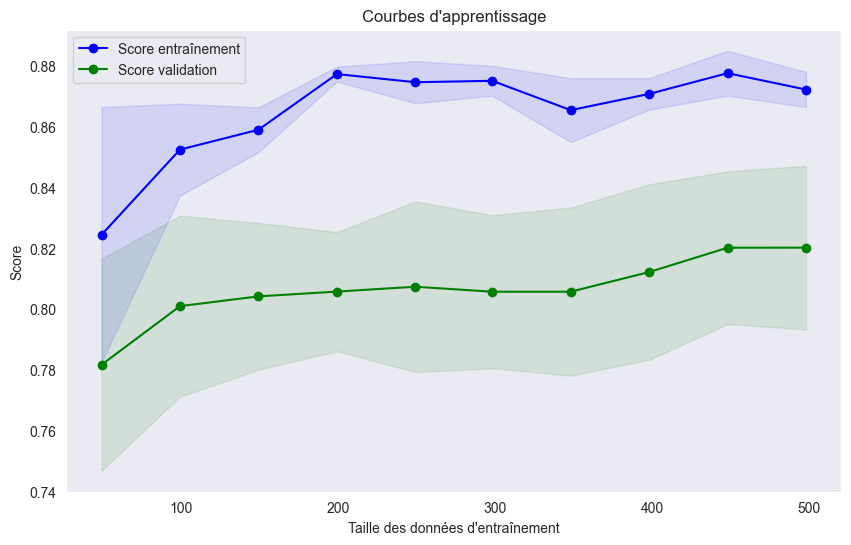

In [21]:
randomforest = RandomForestClassifier(max_depth=10,max_features='sqrt', min_samples_leaf=5,min_samples_split=2,n_estimators=100)
randomforest.fit(train, y_train)

# feature_minimum = 0.01
# features_to_keep = features_importance[features_importance > feature_minimum].index.tolist()
# train = pd.DataFrame(train)
test = pd.DataFrame(data = test)
test = test.loc[:, features_to_keep]



y_pred = randomforest.predict(test)



# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")


plot_learning_curves(randomforest, train, y_train, cv=5)

# Essai avec LightGBM


In [22]:
lgbm = LGBMClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],                
    'max_depth': [3, 5, 7],                       
    'learning_rate': [0.01, 0.1, 0.2],             
    'num_leaves': [15, 31, 63],                    
    'min_child_samples': [5, 10, 20],              
    'subsample': [0.6, 0.8, 1.0],                  
    'colsample_bytree': [0.6, 0.8, 1.0]            
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=2
)


grid_search.fit(train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score de validation :", grid_search.best_score_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
[LightGBM] [Info] Number of positive: 242, number of negative: 381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388443 -> initscore=-0.453862
[LightGBM] [Info] Start training from score -0.453862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[LightGBM] [Info] Number of positive: 242, number of negative: 381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388443 -> initscore=-0.453862
[LightGBM] [Info] Start training from score -0.453862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

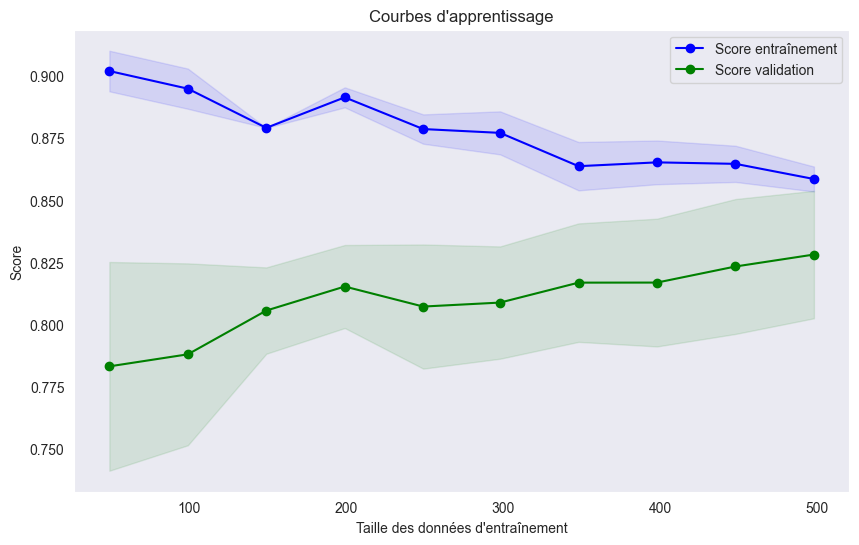

In [23]:
lgbm = LGBMClassifier(**grid_search.best_params_, random_state=42)
lgbm.fit(train, y_train)


y_pred = lgbm.predict(test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")


plot_learning_curves(lgbm, train, y_train, cv=5)

In [24]:
GBC = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    estimator=GBC,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train, y_train)

print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score de validation :", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Meilleurs paramètres trouvés : {'learning_rate': 0.1, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Meilleur score de validation : 0.8346709677419355


Accuracy: 0.82
Precision: 0.78
Recall: 0.72
F1-Score: 0.75
ROC AUC: 0.80


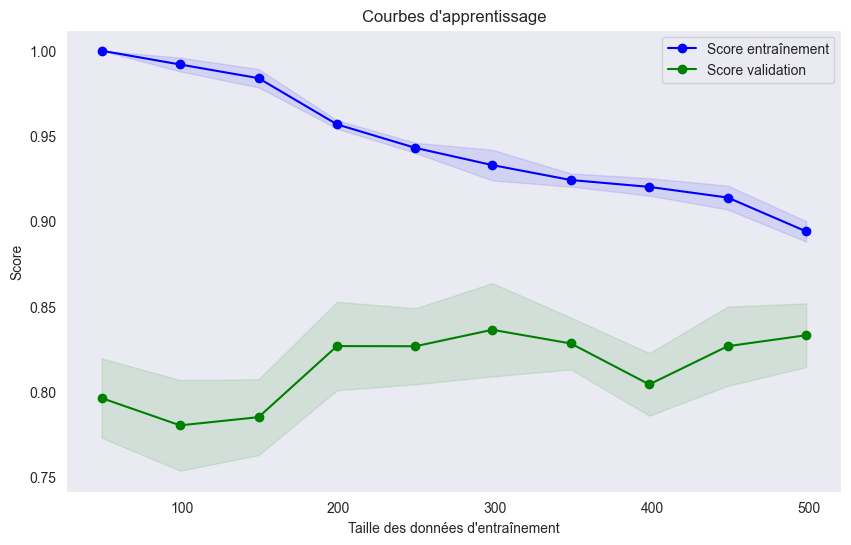

In [25]:
GBM = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)

GBM.fit(train, y_train)
y_pred = GBM.predict(test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")


plot_learning_curves(GBM, train, y_train, cv=5)

In [26]:
final = pd.read_csv('data/test.csv', sep=',')

x_final = final
print(x_final.columns)


x_final_transformed = preprocessor.transform(x_final)
x_final_transformed = np.reshape(np.array(x_final_transformed).ravel(), x_final_transformed.shape)
final_x = inputer.transform(x_final_transformed)

feature_minimum = 0.01
features_to_keep = features_importance[features_importance > feature_minimum].index.tolist()
final_x = pd.DataFrame(data=final_x)
final_x = final_x.loc[:, features_to_keep]

y_pred = GBM.predict(final_x)
y_pred = pd.DataFrame({'PassengerId':x_final.PassengerId,'Survived': y_pred})

y_pred.to_csv('predictions.csv', index = False)


print(y_pred)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
